In [385]:
import sys
#sys.path.append("../DBL-Data-Challenge")
from database.connect import getConnection
from langdetect import detect
import pandas as pd
import seaborn as sns
sns.set()
import random
import matplotlib.pyplot as plt
from globals import airlineIDs
import re

In [386]:
try:
    connection1 = getConnection()
except Exception:
    print("✖️ Error while connecting to MySQL engine database.")
    print("ℹ️ Please make sure the environment file `.env` is located at"+
        "the project root directory and contains proper configuration.")
    raise

In [387]:
"""Loads all the relevant data
"""

# Connects to database
cursor = connection1.cursor()

print("The tweets are being queried")
query="SELECT text, user_id, user_mentions FROM tweets"
cursor.execute(query)

print('The tweets are being fetched')
texts = cursor.fetchall()
number_tweets = cursor.rowcount
print("Total number of rows in table: ", number_tweets)

# Remove this after runnin the final time
query="ALTER TABLE tweets DROP COLUMN lang;"
cursor.execute(query)

print("A new column is being added")
query="ALTER TABLE tweets ADD lang VARCHAR(10)"
cursor.execute(query)
connection1.commit()
print('New column added')

# Index column is being added
print("Index is being added")
query= "DROP TABLE tweets_with_index"
cursor.execute(query)

# Create new table will the relevant data
query= "CREATE TABLE tweets_with_index SELECT ROW_NUMBER() OVER() AS row_num, text, lang, user_id, user_mentions FROM tweets"
cursor.execute(query)
print('Index added')

# Generate random list
randomlist = []
for i in range(0, 6000):
    n = random.randint(0, number_tweets-1)
    randomlist.append(n)

# Make list of languages
print("The language is being detected")
lang_list = []
user_mention_list = []
for i in randomlist:  
    try:
        lang_list.append(detect(str(texts[i][0])))
    except Exception:
        lang_list.append('NI')
    try:
        dicts_str = (texts[i][2])
        tweet_mentions_list = re.findall("'id':\s*(\d*)", dicts_str)
        user_mention_list.append(tweet_mentions_list)
    except:
        user_mention_list.append('Null')


# Add the result to the table (Probably needs some modifications)
"""
print("The tweets are being added to the table")
for i, j in enumerate(lang_list): # i = index, j = language
    query = f"UPDATE tweets_with_index SET lang = '{str(j)}' WHERE row_num = {int(i+1)}"
    cursor.execute(query)
"""

"""
print("A selection is being fetched to show that everything when correctly")
query = "SELECT * FROM tweets_with_index LIMIT 5"
cursor.execute(query)
head = cursor.fetchall()

print("The first 5 rows are being printed:")
for row in head:
    print(row)

"""
cursor.close()
connection1.close()
print('Connection closed!')


The tweets are being queried
The tweets are being fetched
Total number of rows in table:  6094135
A new column is being added
New column added
Index is being added
Index added
The language is being detected
('RT @presroi: VW: Mist, Corona. \nAirbus: Scheiße, Corona.\nLufthansa: WTF, Corona.\nTUI: OMG, Corona.\n\nVorwerk: Geil, Corona, da sind alle Kun…', 281072753, "[{'screen_name': 'presroi', 'name': 'Mathias Schindler', 'id': 20447568, 'id_str': '20447568', 'indices': [3, 11]}]")
('@British_Airways', 394376606, "[{'screen_name': 'British_Airways', 'name': 'British Airways', 'id': 18332190, 'id_str': '18332190', 'indices': [0, 16]}]")
[{'screen_name': 'presroi', 'name': 'Mathias Schindler', 'id': 20447568, 'id_str': '20447568', 'indices': [3, 11]}]
['20447568']
('RT @Hashira_EKT: コミケ徹夜組にはぜひ下記の航空機のどれかに乗ってもらいたい\n\n･パン･アメリカン航空103便\n\n･トランス・ワールド航空800便\n\n･エア・インディア182便\n\n･トルコ航空981便\n\n･サウジアラビア航空182便\n\n･アメリカン航空191便…', 101972571, "[{'screen_name': 'Hashira_EKT', 'name': 'エカテリーナ書記長', 'id': 

In [ ]:
# Lang list to pandas
lang_df = pd.DataFrame(data=lang_list)
lang_df.rename(columns={0: 'lang'}, inplace=True)

In [492]:
# Add user mentions
lang_df['mentions'] = user_mention_list
lang_df

lang                           mentions
0      en                         [20447568]
1      ja              [1033551266155098112]
2      en    [34908970, 630959591, 56377143]
3      en             [1390463672, 18332190]
4      en                         [41775413]
...   ...                                ...
5995   it  [382900093, 330510986, 218730857]
5996   en                       [1449525326]
5997   en                        [544750743]
5998   en                         [38676903]
5999   en                       [2280470022]

[6000 rows x 2 columns]

In [493]:
lang_df['user_mentions'] = 'Null'
lang_df['airline'] = 'Null'

# For every list of mentions per tweet
for i, mentions in enumerate(lang_df['mentions']):

    mentions_list = []
    airline = 'no_airline'
    # check for every mention
    for mention in mentions:
        # if the mention is an airline
        added = False
        for key in airlineIDs:
            if int(mention) == int(airlineIDs[key]):
                mentions_list.append(key)
                airline = key
                added = True
                continue
        if added == False:
            mentions_list.append('not_airline')
    if added == False:
        airline = 'no_airline'
        #airlines.append('no_airline')
    lang_df['user_mentions'][i] = mentions_list
    lang_df['airline'][i] = airline

#lang_df = lang_df.drop(labels=-1, axis=0)
lang_df


lang                           mentions  \
0      en                         [20447568]   
1      ja              [1033551266155098112]   
2      en    [34908970, 630959591, 56377143]   
3      en             [1390463672, 18332190]   
4      en                         [41775413]   
...   ...                                ...   
5995   it  [382900093, 330510986, 218730857]   
5996   en                       [1449525326]   
5997   en                        [544750743]   
5998   en                         [38676903]   
5999   en                       [2280470022]   

                           user_mentions         airline  
0                          [not_airline]      no_airline  
1                          [not_airline]      no_airline  
2        [not_airline, not_airline, KLM]             KLM  
3          [not_airline, BritishAirways]  BritishAirways  
4                          [not_airline]      no_airline  
...                                  ...             ...  
5995  [not_airline, not_airline, Qantas]          Qantas  
5996                       [not_airline]      no_airline  
5997                       [not_airline]      no_airline  
5998                           [easyJet]         easyJet  
5999                       [not_airline]      no_airline  

[6000 rows x 4 columns]

In [641]:
# Only look at top 5 languages
output = pd.DataFrame(columns = ['lang', 'count'])

grouped = lang_df.groupby('lang')
groups = grouped.groups 
for key in groups:
    lang_count = {'lang': key, 'count': len(groups[key])}
    df_dictionary = pd.DataFrame([lang_count])
    output = pd.concat([output, df_dictionary], ignore_index=True)

output = output.sort_values(by='count', ascending= 0)
output.head()



lang count
9    en  4426
10   es   376
14   fr   241
26   nl   185
7    de   102

In [642]:
top_5 = pd.DataFrame()
df_dictionary = top_5.from_dict([{'lang': 'other', 'count': output[4:].sum()[1]}])
top_5 = pd.concat([output[0:4], df_dictionary], ignore_index=True)

for i in range(0, 5):
    top_5.loc[i, 'percentage'] = (top_5.loc[i,'count'])/6000

top_5 = top_5.sort_values(by='count', ascending= 0)
top_5

lang count  percentage
0     en  4426    0.737667
4  other   772    0.128667
1     es   376    0.062667
2     fr   241    0.040167
3     nl   185    0.030833

In [510]:
top4_lang = ['en', 'es', 'fr', 'nl']

In [648]:
lang_df['count'] = 0
grouped_lang = lang_df.groupby(['airline', 'lang'])['count'].count()

#grouped_lang = grouped.count()
grouped_lang = grouped_lang.to_frame()

#grouped_lang = grouped_lang.unstack()
#df = grouped_lang.fillna(0)
#grouped_lang = grouped_lang.sort_values(by='count', ascending= 0)
grouped_lang.head()


count
airline   lang       
AirFrance en       40
          es        2
          fr       13
          it        2
          pt        1

In [649]:
df = (grouped_lang
    .unstack(0)
    .reindex(pd.unique(grouped_lang.index.get_level_values(1)))
    .sort_index(axis=1, level=1)
    )
df = df.fillna(0)

df.head()


count                                                            \
airline AirFrance AmericanAir BritishAirways EtihadAirways    KLM Lufthansa   
lang                                                                          
en           40.0       587.0          398.0          43.0  110.0      79.0   
es            2.0         8.0            3.0           2.0    7.0       5.0   
fr           13.0         0.0            1.0           0.0    2.0       2.0   
it            2.0         1.0            2.0           0.0    0.0       0.0   
pt            1.0         4.0            0.0           0.0    1.0       0.0   

                                                                       
airline Qantas RyanAir SingaporeAir VirginAtlantic easyJet no_airline  
lang                                                                   
en       130.0   186.0         50.0          104.0   246.0     2453.0  
es         1.0     7.0          0.0            0.0     7.0      334.0  
fr         2.0     6.0          0.0            0.0    16.0      199.0  
it         2.0     0.0          0.0            2.0     0.0       56.0  
pt         0.0     1.0          0.0            0.0     1.0       23.0

In [686]:
other = df[4:].sum().to_frame()
other.rename(columns={0: 'count'}, inplace=True)
other['other'] = other['count']
other = other['count'].unstack()
other.head()

airline  AirFrance  AmericanAir  BritishAirways  EtihadAirways   KLM  \
count          1.0          9.0             9.0           14.0  52.0   

airline  Lufthansa  Qantas  RyanAir  SingaporeAir  VirginAtlantic  easyJet  \
count         15.0     6.0     33.0           7.0             3.0     11.0   

airline  no_airline  
count         732.0

In [677]:
other = df[4:].sum()
other = other.to_frame()
other = other[0]['count'].to_frame()
other = other.unstack()
other.to_frame()
other.head()

   airline       
0  AirFrance          1.0
   AmericanAir        9.0
   BritishAirways     9.0
   EtihadAirways     14.0
   KLM               52.0
dtype: float64

In [663]:
other = df[4:].sum()
other = other.to_frame()
other.rename(columns={0: 'count'}, inplace=True)
other = other.unstack()
other.head()

count                                                           \
airline AirFrance AmericanAir BritishAirways EtihadAirways   KLM Lufthansa   
count         1.0         9.0            9.0          14.0  52.0      15.0   

                                                                       
airline Qantas RyanAir SingaporeAir VirginAtlantic easyJet no_airline  
count      6.0    33.0          7.0            3.0    11.0      732.0

In [698]:
# Top 5 languages
top_lang = df[:4]
#top5 = top5[lang]
#top5 = top5.to_frame()
#top5.rename(columns={0: 'count'}, inplace=True)
top_lang

count                                                            \
airline AirFrance AmericanAir BritishAirways EtihadAirways    KLM Lufthansa   
lang                                                                          
en           40.0       587.0          398.0          43.0  110.0      79.0   
es            2.0         8.0            3.0           2.0    7.0       5.0   
fr           13.0         0.0            1.0           0.0    2.0       2.0   
it            2.0         1.0            2.0           0.0    0.0       0.0   

                                                                       
airline Qantas RyanAir SingaporeAir VirginAtlantic easyJet no_airline  
lang                                                                   
en       130.0   186.0         50.0          104.0   246.0     2453.0  
es         1.0     7.0          0.0            0.0     7.0      334.0  
fr         2.0     6.0          0.0            0.0    16.0      199.0  
it         2.0     0.0          0.0            2.0     0.0       56.0

<Axes: xlabel='None,airline'>

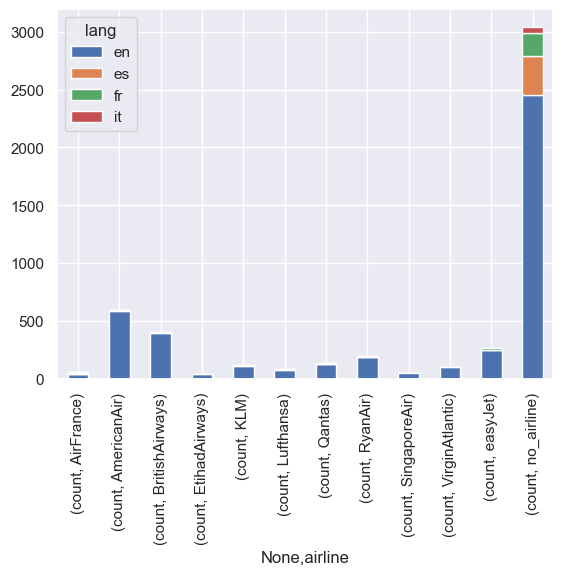

In [699]:
top_langT = top_lang.T
top_langT.plot(kind='bar', stacked=True, )

In [665]:
top_lang = pd.concat([top_lang, other], ignore_index=False)
top_lang.head()

count                                                            \
airline AirFrance AmericanAir BritishAirways EtihadAirways    KLM Lufthansa   
en           40.0       587.0          398.0          43.0  110.0      79.0   
es            2.0         8.0            3.0           2.0    7.0       5.0   
fr           13.0         0.0            1.0           0.0    2.0       2.0   
it            2.0         1.0            2.0           0.0    0.0       0.0   
count         1.0         9.0            9.0          14.0   52.0      15.0   

                                                                       
airline Qantas RyanAir SingaporeAir VirginAtlantic easyJet no_airline  
en       130.0   186.0         50.0          104.0   246.0     2453.0  
es         1.0     7.0          0.0            0.0     7.0      334.0  
fr         2.0     6.0          0.0            0.0    16.0      199.0  
it         2.0     0.0          0.0            2.0     0.0       56.0  
count      6.0    33.0          7.0            3.0    11.0      732.0

In [694]:
top_lang = top_lang.T
top_lang.rename(columns={'count': 'other'}, inplace=True)
top_lang.head()


en   es    fr   it  other
      airline                                     
other AirFrance        40.0  2.0  13.0  2.0    1.0
      AmericanAir     587.0  8.0   0.0  1.0    9.0
      BritishAirways  398.0  3.0   1.0  2.0    9.0
      EtihadAirways    43.0  2.0   0.0  0.0   14.0
      KLM             110.0  7.0   2.0  0.0   52.0

<Axes: xlabel='None,airline'>

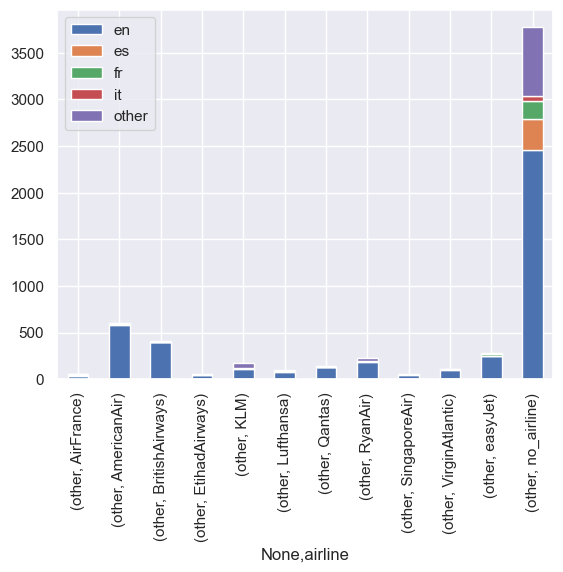

In [697]:
top_lang.plot(kind='bar', stacked=True)


In [451]:
lang_df[['lang', 'airline']].describe()

lang        airline
count   6000           6000
unique    42            288
top       en  [not_airline]
freq    4426           2138

In [ ]:
output = pd.DataFrame(columns = ['lang', 'count'])

grouped = lang_df.groupby('lang')
groups = grouped.groups 
for key in groups:
    lang_count = {'lang': key, 'count': len(groups[key])}
    #print(lang_count)


    df_dictionary = pd.DataFrame([lang_count])
    output = pd.concat([output, df_dictionary], ignore_index=True)
print(output.head())

output = output.sort_values(by='count', ascending= 0)
output.head()


  lang count
0   en     4
1   fr     1


lang count
0   en     4
1   fr     1

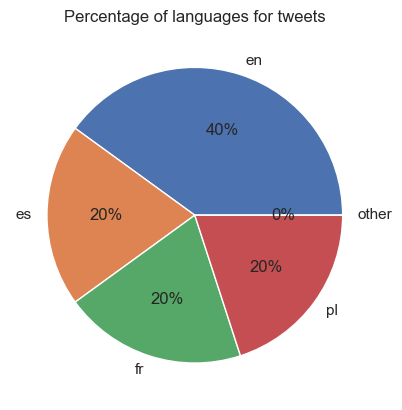

In [ ]:
plt.pie(top_10['count'], labels = top_10['lang'], autopct='%.0f%%')
plt.title('Percentage of languages for tweets')
plt.show()

Text(0, 0.5, 'Number of tweets')

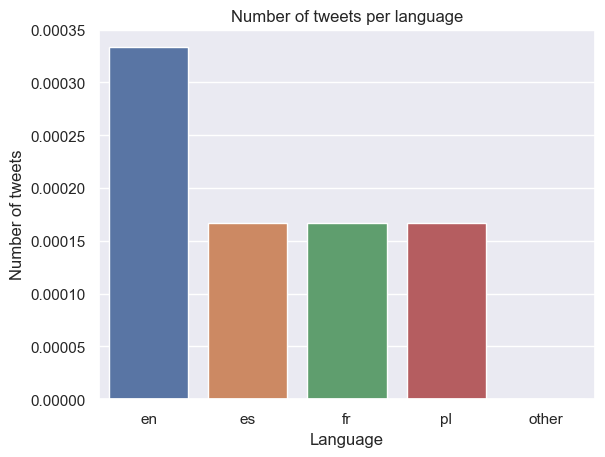

In [ ]:
ax = sns.barplot(x=top_10["lang"], y=top_10["percentage"], order = top_10['lang'].value_counts().index)
ax.set_title("Number of tweets per language")
ax.set_xlabel('Language')
ax.set_ylabel('Number of tweets')


In [ ]:
top_10 = pd.DataFrame()
df_dictionary = top_10.from_dict([{'lang': 'other', 'count': output[4:].sum()[1]}])
top_10 = pd.concat([output[0:4], df_dictionary], ignore_index=True)

for i in range(0, 5):
    top_10.loc[i, 'percentage'] = (top_10.loc[i,'count'])/6000

top_10 = top_10.sort_values(by='count', ascending= 0)
top_10

lang count  percentage
0     en  8844    1.474000
4  other  1536    0.256000
1     es   753    0.125500
2     fr   476    0.079333
3     nl   391    0.065167